<center><h1 style="font-family: 'Georgia'; color: #f2f2f2; background-color:#800040; padding: 20px;">Optimization: Text Message Spam Detection
    </h1></center>

<p style="font-family: 'Georgia'; font-size: 16px; font-weight: 800; color: #800040;">
This is the optimization for the 70-30 dataset. The model with highest performance in training was Bernoulli Naive Bayes
</p>

<h1 style="font-family: 'Georgia'; font-size: 24px; color: #008000;">Import Libraries and Load Dataset</h1>

In [39]:
#IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [6]:
#LOAD THE DATASET
df = pd.read_csv('../datasets/training_datasets/training_data7030.csv') 
df.head(10)

,tag,message_transformed
0,0,shop lor rain mah hard 2 leav orchard
1,0,u still paint ur wall
2,0,lol oh got friend dog
3,0,sure get acknowledg astoundingli tactless gene...
4,0,stuck da middl da row da right hand side da lt
5,0,u get messag
6,0,gal n boy walk park hold ur hand u think would...
7,0,hi juan im come home fri hey cours expect welc...
8,0,ok need tell anyth go sleep good night
9,0,yep pretti sculptur


In [7]:
# RENAME TO PROPER COLUMN NAMES
df.rename(columns = {'tag' : 'tag',
                      'message_transformed' : 'message'}, 
          inplace=True)
df.columns

Index(['tag', 'message'], dtype='object')

In [8]:
# IT SEEMS LIKE WE HAVE NULL VALUES FROM SAVING THE DATASET, WE NEED TO DELETE THESE NULL VALUES FIRST
df.dropna(inplace=True)
df.isnull().sum()

tag        0
message    0
dtype: int64

<h1 style="font-family: 'Georgia'; font-size: 24px; color: #008000;">Vectorize Data</h1>

In [9]:
#Vectorizers will transform textual data to an array of numerical data
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X = cv.fit_transform(df['message']).toarray() # array of numeric values
y = df['tag'].values                       # numeric values

<h1 style="font-family: 'Georgia'; font-size: 24px; color: #008000;">Split the Dataset</h1>

In [10]:
# SPLIT THE DATASET
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8, random_state=0)

<h1 style="font-family: 'Georgia'; font-size: 24px; color: #008000;">Loading the Model</h1>

In [12]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

<h1 style="font-family: 'Georgia'; font-size: 24px; color: #008000;">Randomized Search CV</h1>

In [14]:
from sklearn.model_selection import StratifiedKFold
k_Fold = StratifiedKFold (n_splits=5, shuffle=True, random_state=0)

# To Import the RandomizedSearch Class
from sklearn.model_selection import RandomizedSearchCV

In [20]:
# To Set Parameters to be Optimized Under the Bernoulli Naive Bayes Model

parameters = {
    'alpha': [0.0, 0.1, 0.05, 0.1, 0.05, 1.0, 2.0],
    'binarize': [None, 0.0, 0.1, 0.5, 1.0],
    'class_prior': [None, [0.2, 0.8], [0.5, 0.5]],
    'fit_prior': [True, False],
    'force_alpha': [False, True],  # Assuming 'force_alpha' is a custom parameter
}


randomized_search = RandomizedSearchCV(estimator = bnb,
                                       param_distributions = parameters,
                                       n_iter = 70,
                                       scoring = 'accuracy',
                                       cv = k_Fold,
                                       n_jobs = -1,
                                       random_state = 0)

randomized_search = randomized_search.fit(X, y)

In [22]:
# To Identify the Best Accuracy and Best Features
best_accuracy = randomized_search.best_score_
best_parameters= randomized_search.best_params_

print('Best Accuracy:', best_accuracy)
print()
print('Best Parameters:', best_parameters)

Best Accuracy: 0.9732558139534884

Best Parameters: {'force_alpha': False, 'fit_prior': True, 'class_prior': None, 'binarize': None, 'alpha': 0.1}


<h1 style="font-family: 'Georgia'; font-size: 24px; color: #008000;">Train a Model Using Optimized Parameters(Cross Validation)</h1>

In [33]:
bnb_optimized = BernoulliNB(force_alpha=False,
                            fit_prior=True,
                            class_prior=None, 
                            binarize=None,
                            alpha=0.1)

In [34]:
models = {
    'BNB' : bnb_optimized
}

# STORE METRICS FOR VISUALIZATION
accuracy_list_cv = []
precision_list_cv = []
recall_list_cv = []
f1_list_cv = []


# DEFINE EVALUATION METRICS
scoring = ['accuracy', 'precision', 'recall', 'f1']

# KFOLDS CONFIGURATION
num_folds = 5

cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

In [35]:
# Loop through each model and perform cross-validation
for name, model in models.items():
    scores = cross_validate(estimator=model, X=X, y=y, cv=cv, scoring=scoring)
    
    mean_accuracy = np.mean(scores['test_accuracy'])
    mean_precision = np.mean(scores['test_precision'])
    mean_recall = np.mean(scores['test_recall'])
    mean_f1 = np.mean(scores['test_f1'])
    
    accuracy_list_cv.append(mean_accuracy)
    precision_list_cv.append(mean_precision)
    recall_list_cv.append(mean_recall)
    f1_list_cv.append(mean_f1)

    print(f'For {name}:')
    print(f'\t Mean Accuracy: {mean_accuracy}')
    print(f'\t Mean Precision: {mean_precision}')
    print(f'\t Mean Recall: {mean_recall}')
    print(f'\t Mean F1 Score: {mean_f1}')


For BNB:
	 Mean Accuracy: 0.9732558139534884
	 Mean Precision: 0.9819691303815283
	 Mean Recall: 0.9280057466103978
	 Mean F1 Score: 0.9542035469308582


In [36]:
#CREATE A DATAFRAME TO FOR GRAPHICAL VISUALIZATION
model_performance_cv = pd.DataFrame({'Algorithm' : models.keys(), 
                                  'Accuracy' : accuracy_list_cv, 
                                  'Precision' : precision_list_cv,
                                  'Recall' : recall_list_cv,
                                  'F1 Score' : f1_list_cv})
model_performance_cv.sort_values('Accuracy', ascending=False)

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,BNB,0.973256,0.981969,0.928006,0.954204


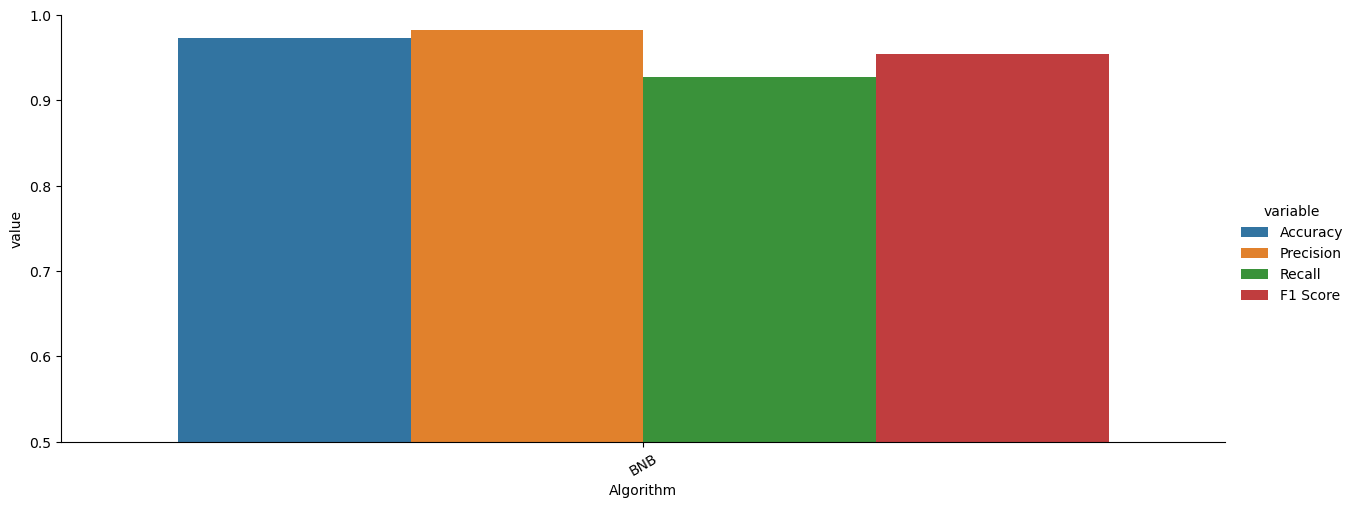

In [41]:
#TO VISUALIZE performance_df1
performance_df_cv = pd.melt(model_performance_cv, id_vars="Algorithm")

sns.catplot(x='Algorithm', 
            y='value', 
            hue='variable', 
            data=performance_df_cv, 
            kind='bar', 
            height=5, 
            aspect=2.5)  # Adjust the aspect value for width
plt.ylim(0.5, 1.0)
plt.xticks(rotation=30)
plt.show()

<p style="font-family: 'Georgia'; font-size: 16px; font-weight: 800; color: #800040;">
    Accuracy: 97.32%
</p>
<p style="font-family: 'Georgia'; font-size: 16px; font-weight: 800; color: #800040;">
    Precision: 98.20%
</p>
<p style="font-family: 'Georgia'; font-size: 16px; font-weight: 800; color: #800040;">
    Recall: 92.80%
</p>
<p style="font-family: 'Georgia'; font-size: 16px; font-weight: 800; color: #800040;">
    F1 Score: 95.42%
</p>